# Classic Risk Premia Portfolio Backtest

In this notebook we backtest a classic long-only portfolio of ETFs.

Profits are re-invested.

Rebalancing occurs ad-hoc when the asset weights exceed the target weights by a margin greater than the 'trade buffer'.

A minimum fixed commission per trade is modelled. In this scheme trading back to the ideal target weight is recommended.

Contrast with a percentage commission scheme where trading back to the buffer limit only is considered optimal.

In [12]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

%matplotlib inline

# Hack to ensure the notebook can load local modules by appending the parent directory to the system path
# Ensure a '.env' file is in the workspace root so location can be detected
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv('donotdelete.env')))

import alphasim.backtest
importlib.reload(alphasim.backtest)
from alphasim.backtest import backtest

import alphasim.stats
importlib.reload(alphasim.stats)
from alphasim.stats import calc_stats, calc_log_returns, calc_rolling_ann_vola


In [13]:
price_df = pdr.get_data_yahoo(['VTI', 'TLT', 'GLD'])
price_df = price_df['Adj Close']
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2017-10-09,120.264015,111.911873,122.080002
2017-10-10,120.548782,112.092369,122.400002
2017-10-11,120.714119,112.309036,122.790001
2017-10-12,120.567123,112.787453,122.889999
2017-10-13,120.659004,113.599861,123.820000
...,...,...,...
2022-10-03,184.029999,103.830002,158.429993
2022-10-04,189.940002,103.540001,160.699997
2022-10-05,189.580002,102.550003,159.809998


In [14]:
weight_df = price_df.copy()
weight_df[:] = [0.6, 0.3, 0.1]
display(weight_df)

Symbols,VTI,TLT,GLD
Date,,,
2017-10-09,0.6,0.3,0.1
2017-10-10,0.6,0.3,0.1
2017-10-11,0.6,0.3,0.1
2017-10-12,0.6,0.3,0.1
2017-10-13,0.6,0.3,0.1
...,...,...,...
2022-10-03,0.6,0.3,0.1
2022-10-04,0.6,0.3,0.1
2022-10-05,0.6,0.3,0.1


In [15]:
def fixed_min_commission(trade_price, trade_size):
    return 10

result = backtest(
    prices=price_df, 
    weights=weight_df, 
    trade_buffer=0.04, 
    do_limit_trade_size=False, 
    commission_func=fixed_min_commission,
    initial_capital=10000,
    do_reinvest=True)

display(result)

price  start_portfolio        equity  current_weight  \
datetime   Symbols                                                              
2017-10-09 VTI      120.264015         0.000000      0.000000        0.000000   
           TLT      111.911873         0.000000      0.000000        0.000000   
           GLD      122.080002         0.000000      0.000000        0.000000   
           cash       1.000000     10000.000000  10000.000000        1.000000   
2017-10-10 VTI      120.548782        49.890235   6014.207100        0.601922   
...                        ...              ...           ...             ...   
2022-10-06 cash       1.000000       672.530390    672.530390        0.050090   
2022-10-07 VTI      182.190002        41.932929   7639.760465        0.581030   
           TLT      101.089996        35.032521   3541.437372        0.269338   
           GLD      158.085007         8.191350   1294.929590        0.098484   
           cash       1.000000       672.530390    672.530390        0.051148   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2017-10-09 VTI       6.000000e-01      0.600000      True           0.600000   
           TLT       3.000000e-01      0.300000      True           0.300000   
           GLD       1.000000e-01      0.100000      True           0.100000   
           cash      1.110223e-16     -1.000000     False           1.000000   
2017-10-10 VTI       6.000000e-01     -0.001922     False           0.601922   
...                           ...           ...       ...                ...   
2022-10-06 cash      1.110223e-16     -0.050090     False           0.050090   
2022-10-07 VTI       6.000000e-01      0.018970     False           0.581030   
           TLT       3.000000e-01      0.030662     False           0.269338   
           GLD       1.000000e-01      0.001516     False           0.098484   
           cash      1.110223e-16     -0.051148     False           0.051148   

                    adj_delta_weight  trade_value  trade_size  commission  \
datetime   Symbols                                                          
2017-10-09 VTI                   0.6       6000.0   49.890235        10.0   
           TLT                   0.3       3000.0   26.806807        10.0   
           GLD                   0.1       1000.0    8.191350        10.0   
           cash                  0.0          0.0    0.000000         0.0   
2017-10-10 VTI                   0.0          0.0    0.000000         0.0   
...                              ...          ...         ...         ...   
2022-10-06 cash                  0.0          0.0    0.000000         0.0   
2022-10-07 VTI                   0.0          0.0    0.000000         0.0   
           TLT                   0.0          0.0    0.000000         0.0   
           GLD                   0.0          0.0    0.000000         0.0   
           cash                  0.0          0.0    0.000000         0.0   

                    end_portfolio  
datetime   Symbols                 
2017-10-09 VTI          49.890235  
           TLT          26.806807  
           GLD           8.191350  
           cash        -30.000000  
2017-10-10 VTI          49.890235  
...                           ...  
2022-10-06 cash        672.530390  
2022-10-07 VTI          41.932929  
           TLT          35.032521  
           GLD           8.191350  
           cash        672.530390  

[5036 rows x 13 columns]

In [16]:
trades_df = result.loc[result['do_trade'] == True]
display(len(trades_df))
display(trades_df)

16

price  start_portfolio       equity  current_weight  \
datetime   Symbols                                                             
2017-10-09 VTI      120.264015         0.000000     0.000000        0.000000   
           TLT      111.911873         0.000000     0.000000        0.000000   
           GLD      122.080002         0.000000     0.000000        0.000000   
2018-08-07 VTI      137.197174        49.890235  6844.799278        0.640454   
2018-12-20 VTI      117.989212        46.738907  5514.686782        0.556830   
2020-03-09 VTI      132.790436        50.362490  6687.657010        0.542216   
           TLT      164.092438        26.806807  4398.794343        0.356642   
2020-03-23 VTI      107.296577        55.729636  5979.599255        0.559646   
2020-04-08 VTI      131.812057        59.748138  7875.524951        0.645891   
2020-06-04 TLT      151.230652        22.549372  3410.156166        0.258305   
2020-06-05 VTI      155.996841        55.502955  8658.285709        0.648383   
2021-01-05 TLT      151.548309        26.189263  3968.938577        0.259987   
2021-01-06 VTI      190.445480        51.361248  9781.517611        0.642472   
2021-03-12 VTI      202.389801        47.965876  9707.804108        0.640969   
2021-04-27 TLT      134.866837        30.219948  4075.668830        0.258788   
2022-09-12 VTI      205.776382        44.900038  9239.367421        0.642455   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2017-10-09 VTI                0.6      0.600000      True                0.6   
           TLT                0.3      0.300000      True                0.3   
           GLD                0.1      0.100000      True                0.1   
2018-08-07 VTI                0.6     -0.040454      True                0.6   
2018-12-20 VTI                0.6      0.043170      True                0.6   
2020-03-09 VTI                0.6      0.057784      True                0.6   
           TLT                0.3     -0.056642      True                0.3   
2020-03-23 VTI                0.6      0.040354      True                0.6   
2020-04-08 VTI                0.6     -0.045891      True                0.6   
2020-06-04 TLT                0.3      0.041695      True                0.3   
2020-06-05 VTI                0.6     -0.048383      True                0.6   
2021-01-05 TLT                0.3      0.040013      True                0.3   
2021-01-06 VTI                0.6     -0.042472      True                0.6   
2021-03-12 VTI                0.6     -0.040969      True                0.6   
2021-04-27 TLT                0.3      0.041212      True                0.3   
2022-09-12 VTI                0.6     -0.042455      True                0.6   

                    adj_delta_weight  trade_value  trade_size  commission  \
datetime   Symbols                                                          
2017-10-09 VTI              0.600000  6000.000000   49.890235        10.0   
           TLT              0.300000  3000.000000   26.806807        10.0   
           GLD              0.100000  1000.000000    8.191350        10.0   
2018-08-07 VTI             -0.040454  -432.353349   -3.151328        10.0   
2018-12-20 VTI              0.043170   427.543743    3.623583        10.0   
2020-03-09 VTI              0.057784   712.705702    5.367146        10.0   
           TLT             -0.056642  -698.612987   -4.257436        10.0   
2020-03-23 VTI              0.040354   431.171421    4.018501        10.0   
2020-04-08 VTI             -0.045891  -559.566222   -4.245182        10.0   
2020-06-04 TLT              0.041695   550.463195    3.639892        10.0   
2020-06-05 VTI             -0.048383  -646.093196   -4.141707        10.0   
2021-01-05 TLT              0.040013   610.843498    4.030685        10.0   
2021-01-06 VTI             -0.042472  -646.633308   -3.395372    

In [17]:
stats = calc_stats(result)
display(stats)

,equity
start,2017-10-09 00:00:00
end,2022-10-07 00:00:00
rf,0.0
total_return,0.314866
cagr,0.056345
max_drawdown,-0.249298
calmar,0.226013
mtd,0.00789
three_month,-0.065614
six_month,-0.176445


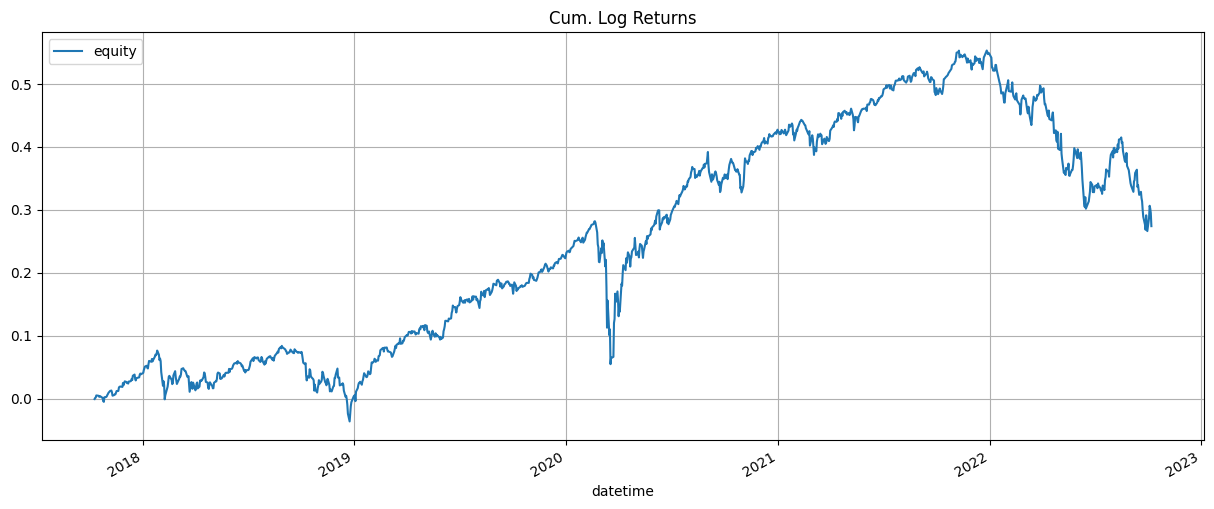

In [18]:
ax = calc_log_returns(result).cumsum().plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Log Returns')
plt.legend(loc=2)
plt.show()

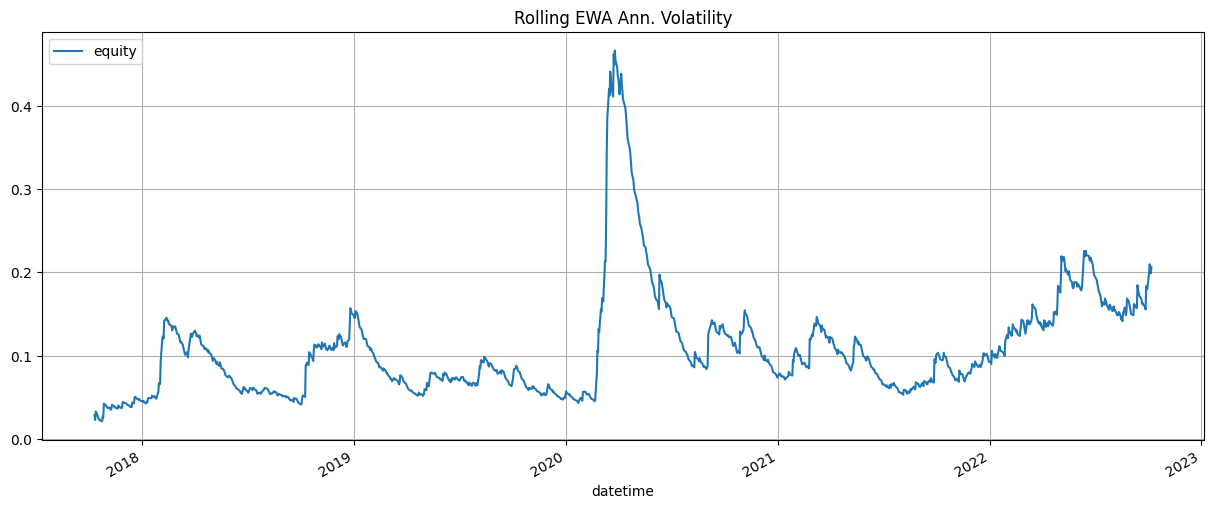

In [19]:
ax = calc_rolling_ann_vola(result).plot(figsize=(15, 6))
ax.grid(True)
plt.title('Rolling EWA Ann. Volatility')
plt.legend(loc=2)
plt.show()